### Import libraries and create DataFrame from csv 

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prompt user for week selection
start_week = int(input("Enter the start week for analysis: "))
end_week = int(input("Enter the end week for analysis (enter the same as start week for single week analysis): "))
weeks = str(start_week) if start_week == end_week else f"{start_week} - {end_week}"

# Function to read, preprocess, group by player, and aggregate data for the selected weeks
def read_data(start_week, end_week):
    data = pd.DataFrame()

    for week in range(start_week, end_week + 1):
        temp_df = pd.read_excel("RB_Data.xlsx", sheet_name=f"Week{week}")

        # Preprocess: Drop irrelevant columns and convert data types
        temp_df.drop(['FL', 'ROST'], axis=1, inplace=True)
        convert = temp_df.select_dtypes('object').columns.difference(['Player'])
        temp_df[convert] = temp_df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)
        temp_df['Rank'] = temp_df['Rank'].astype('Int64')

        # Group by 'Player' and aggregate data
        if data.empty:
            data = temp_df
        else:
            data = data.merge(temp_df, on='Player', suffixes=('', '_week' + str(week)))

    # Apply custom aggregation logic
    for column in data.columns:
        if column.endswith(tuple([f'_week{week}' for week in range(start_week + 1, end_week + 1)])):
            base_column = column.split('_week')[0]
            if base_column in ['Rank', 'Player']:  # Take the latest value
                data[base_column] = data[column]
            elif base_column in ['LG']:  # Take the maximum value
                data[base_column] = data[[base_column, column]].max(axis=1)
            else:  # Sum the values
                data[base_column] += data[column]
            data.drop(column, axis=1, inplace=True)  # Drop the extra week column

    # Calculate 'Y/A' and 'Y/R' based on summed values
    data['Y/A'] = (data['YDS'] / data['ATT']).round(1)
    data['Y/R'] = (data['YDS.1'] / data['REC']).round(1)
    data['FPTS/G'] = (data['FPTS'] / data['G']).round(1)

    return data

# Load and aggregate data for the selected weeks
df = read_data(start_week, end_week)

# Recalculate 'Rank' based on 'FPTS' in descending order
df['Rank'] = df['FPTS'].rank(ascending=False, method='min').astype('int')

# Create 'Weeks' column
if start_week == end_week:
    df['Weeks'] = str(start_week)
else:
    df['Weeks'] = f"{start_week} - {end_week}"

df = df.sort_values(by='Rank')
df.head(10)

,Rank,Player,ATT,YDS,Y/A,LG,20+,TD,REC,TGT,YDS.1,Y/R,TD.1,G,FPTS,FPTS/G,Weeks
1,1,Alvin Kamara (NO),52,189,3.6,17,0,1,27,31,219,8.1,1,4,85.8,21.4,7 - 10
2,2,Jahmyr Gibbs (DET),51,297,5.8,35,5,4,17,20,130,7.6,0,3,83.7,27.9,7 - 10
11,3,Rachaad White (TB),62,197,3.2,16,0,2,19,20,228,12.0,1,4,79.5,19.9,7 - 10
5,4,Gus Edwards (BAL),49,220,4.5,42,4,7,4,4,98,24.5,0,4,77.8,19.4,7 - 10
4,5,Christian McCaffrey (SF),43,194,4.5,19,0,2,15,20,162,10.8,2,3,72.6,24.2,7 - 10
38,6,Austin Ekeler (LAC),62,188,3.0,20,1,3,14,24,166,11.9,1,4,71.4,17.8,7 - 10
6,7,Jonathan Taylor (IND),71,286,4.0,42,4,2,10,12,75,7.5,1,4,64.1,16.0,7 - 10
0,8,D'Onta Foreman (CHI),66,286,4.3,22,1,3,6,9,45,7.5,1,4,63.1,15.8,7 - 10
12,9,Najee Harris (PIT),53,217,4.1,25,2,3,13,16,78,6.0,0,4,60.5,15.1,7 - 10
26,10,Brian Robinson Jr. (WAS),44,183,4.2,29,1,2,9,11,143,15.9,1,4,57.6,14.4,7 - 10


### Convert relevant stats to a per-game basis and create the final stats for analysis

In [196]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/A', 'LG', 'Y/R', 'G', 'FPTS', 'FPTS/G', 'Weeks']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
df[['Rank', 'Player'] + final_columns].head(10)

,Rank,Player,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
1,1,Alvin Kamara (NO),3.6,17,8.1,4,85.8,21.4,7 - 10,13.0,47.2,0.0,0.2,6.8,7.8,54.8,0.2
2,2,Jahmyr Gibbs (DET),5.8,35,7.6,3,83.7,27.9,7 - 10,17.0,99.0,1.7,1.3,5.7,6.7,43.3,0.0
11,3,Rachaad White (TB),3.2,16,12.0,4,79.5,19.9,7 - 10,15.5,49.2,0.0,0.5,4.8,5.0,57.0,0.2
5,4,Gus Edwards (BAL),4.5,42,24.5,4,77.8,19.4,7 - 10,12.2,55.0,1.0,1.8,1.0,1.0,24.5,0.0
4,5,Christian McCaffrey (SF),4.5,19,10.8,3,72.6,24.2,7 - 10,14.3,64.7,0.0,0.7,5.0,6.7,54.0,0.7
38,6,Austin Ekeler (LAC),3.0,20,11.9,4,71.4,17.8,7 - 10,15.5,47.0,0.2,0.8,3.5,6.0,41.5,0.2
6,7,Jonathan Taylor (IND),4.0,42,7.5,4,64.1,16.0,7 - 10,17.8,71.5,1.0,0.5,2.5,3.0,18.8,0.2
0,8,D'Onta Foreman (CHI),4.3,22,7.5,4,63.1,15.8,7 - 10,16.5,71.5,0.2,0.8,1.5,2.2,11.2,0.2
12,9,Najee Harris (PIT),4.1,25,6.0,4,60.5,15.1,7 - 10,13.2,54.2,0.5,0.8,3.2,4.0,19.5,0.0
26,10,Brian Robinson Jr. (WAS),4.2,29,15.9,4,57.6,14.4,7 - 10,11.0,45.8,0.2,0.5,2.2,2.8,35.8,0.2


### Calculate the correlations for the final stats across different conditions

In [197]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G', 'Weeks']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

df_corr.round(2)

,All Players,FPTS > 0,Top 50 Players,Top 25 Players,Correlation
Y/A,0.36,0.31,-0.01,0.05,0.18
LG,0.66,0.60,0.08,-0.12,0.31
Y/R,0.36,0.34,0.38,0.18,0.31
ATT/game,0.87,0.84,0.59,0.29,0.65
YDS/game,0.88,0.85,0.63,0.37,0.68
20+/game,0.47,0.44,0.17,0.10,0.30
TD/game,0.72,0.72,0.57,0.49,0.62
REC/game,0.79,0.75,0.68,0.57,0.70
TGT/game,0.81,0.77,0.69,0.55,0.70
YDS.1/game,0.81,0.78,0.75,0.64,0.74


### Assign the weights for the final stats

In [198]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the calculation to assign weights
def weight_calc(row):
    if row['Correlation'] >= 0.69:
        return 1 + row['R^2']
    else:
        return 1
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, axis=1)

# Display the new columns in the DataFrame
df_corr[['Correlation', 'R^2', 'Weight']].round(2)

,Correlation,R^2,Weight
Y/A,0.18,0.03,1.00
LG,0.31,0.09,1.00
Y/R,0.31,0.10,1.00
ATT/game,0.65,0.42,1.00
YDS/game,0.68,0.46,1.00
20+/game,0.30,0.09,1.00
TD/game,0.62,0.39,1.00
REC/game,0.70,0.49,1.49
TGT/game,0.70,0.50,1.50
YDS.1/game,0.74,0.55,1.55


### Multiply the assigned weights to the final stats

In [199]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df[['Rank', 'Player', 'FPTS/G'] + weight_columns].head(10)

,Rank,Player,FPTS/G,Y/A_weighted,LG_weighted,Y/R_weighted,ATT/game_weighted,YDS/game_weighted,20+/game_weighted,TD/game_weighted,REC/game_weighted,TGT/game_weighted,YDS.1/game_weighted,TD.1/game_weighted
1,1,Alvin Kamara (NO),21.4,3.6,17.0,8.1,13.0,47.2,0.0,0.2,10.1,11.7,85.2,0.2
2,2,Jahmyr Gibbs (DET),27.9,5.8,35.0,7.6,17.0,99.0,1.7,1.3,8.5,10.0,67.3,0.0
11,3,Rachaad White (TB),19.9,3.2,16.0,12.0,15.5,49.2,0.0,0.5,7.1,7.5,88.6,0.2
5,4,Gus Edwards (BAL),19.4,4.5,42.0,24.5,12.2,55.0,1.0,1.8,1.5,1.5,38.1,0.0
4,5,Christian McCaffrey (SF),24.2,4.5,19.0,10.8,14.3,64.7,0.0,0.7,7.4,10.0,84.0,0.7
38,6,Austin Ekeler (LAC),17.8,3.0,20.0,11.9,15.5,47.0,0.2,0.8,5.2,9.0,64.5,0.2
6,7,Jonathan Taylor (IND),16.0,4.0,42.0,7.5,17.8,71.5,1.0,0.5,3.7,4.5,29.2,0.2
0,8,D'Onta Foreman (CHI),15.8,4.3,22.0,7.5,16.5,71.5,0.2,0.8,2.2,3.3,17.4,0.2
12,9,Najee Harris (PIT),15.1,4.1,25.0,6.0,13.2,54.2,0.5,0.8,4.8,6.0,30.3,0.0
26,10,Brian Robinson Jr. (WAS),14.4,4.2,29.0,15.9,11.0,45.8,0.2,0.5,3.3,4.2,55.7,0.2


### Display the columns potentially to be included in the average weighted score

In [200]:
high_corr = df_corr[df_corr['Correlation'] >= 0.69].index.tolist()
conditional_columns = [col + '_weighted' for col in high_corr if col + '_weighted' in df.columns]

# Include 'FPTS/G' in columns to be used for the average weighted score
conditional_columns.append('FPTS/G')

conditional_columns

['REC/game_weighted', 'TGT/game_weighted', 'YDS.1/game_weighted', 'FPTS/G']

### Define the columns to be used for the average weighted score

In [201]:
# Define select columns to be used for the average weighted score
avg = ['ATT/game_weighted',
 'YDS/game_weighted',
 'TD/game_weighted',
 'REC/game_weighted',
 'TGT/game_weighted',
 'YDS.1/game_weighted',
 'FPTS/G']

### Calculate each player's average weighted score and rank them from high to low

In [202]:
# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [203]:
# Display the results for the select columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance'] + final_columns]
analysis.set_index('Rank', inplace=True)
analysis = analysis.sort_values(by='Final Rank', ascending=True)
analysis.head(30)

,Final Rank,Player,Score,Variance,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
Rank,,,,,,,,,,,,,,,,,,,
2,1,Jahmyr Gibbs (DET),33.0,1,5.8,35,7.6,3,83.7,27.9,7 - 10,17.0,99.0,1.7,1.3,5.7,6.7,43.3,0.0
5,2,Christian McCaffrey (SF),29.3,3,4.5,19,10.8,3,72.6,24.2,7 - 10,14.3,64.7,0.0,0.7,5.0,6.7,54.0,0.7
1,3,Alvin Kamara (NO),27.0,-2,3.6,17,8.1,4,85.8,21.4,7 - 10,13.0,47.2,0.0,0.2,6.8,7.8,54.8,0.2
3,4,Rachaad White (TB),26.9,-1,3.2,16,12.0,4,79.5,19.9,7 - 10,15.5,49.2,0.0,0.5,4.8,5.0,57.0,0.2
15,5,Javonte Williams (DEN),23.0,10,3.9,21,5.8,3,52.4,17.5,7 - 10,21.0,82.0,0.3,0.0,3.3,3.7,19.3,0.7
6,6,Austin Ekeler (LAC),22.8,0,3.0,20,11.9,4,71.4,17.8,7 - 10,15.5,47.0,0.2,0.8,3.5,6.0,41.5,0.2
13,7,Saquon Barkley (NYG),22.6,6,4.2,34,5.9,4,56.0,14.0,7 - 10,21.5,90.2,1.0,0.0,2.5,4.0,14.8,0.2
14,8,Travis Etienne Jr. (JAC),22.2,6,3.6,17,12.9,3,55.0,18.3,7 - 10,15.7,55.7,0.0,0.7,2.7,5.0,34.3,0.3
11,9,Rhamondre Stevenson (NE),21.1,2,5.2,64,7.9,4,57.6,14.4,7 - 10,12.0,62.0,1.0,0.2,3.8,5.2,29.5,0.0


### Compare per-game stats of two players and visualize the results

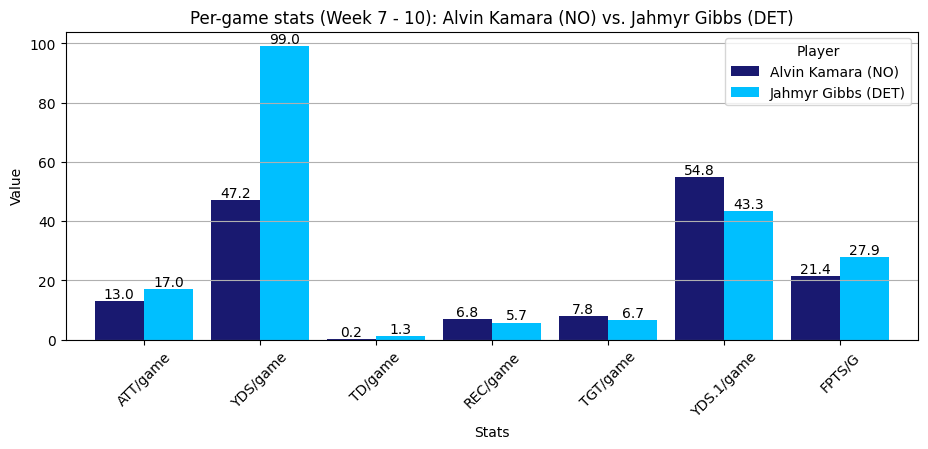

,Final Rank,Y/A,LG,Y/R,G,FPTS,FPTS/G,Weeks,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
Player,,,,,,,,,,,,,,,,
Alvin Kamara (NO),3,3.6,17,8.1,4,85.8,21.4,7 - 10,13.0,47.2,0.0,0.2,6.8,7.8,54.8,0.2
Jahmyr Gibbs (DET),1,5.8,35,7.6,3,83.7,27.9,7 - 10,17.0,99.0,1.7,1.3,5.7,6.7,43.3,0.0


In [204]:
# Prompt the user to input the name of the players
player1 = input("Enter player 1 name")
player2 = input("Enter player 2 name")

# Extract and reorder rows for the two specified players
# Filter rows where the 'Player' column contains the names entered by the user
players = df[df['Player'].str.contains(player1) | df['Player'].str.contains(player2)]
players.set_index('Player', inplace=True)
player1_match = players.index[0] if player1 in players.index[0] else players.index[1]
player2_match = players.index[1] if player2 in players.index[1] else players.index[0]
players = players.reindex([player1_match, player2_match])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats (Week {weeks}): {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1_match, player2_match)
players[['Final Rank'] + final_columns]